# DL session 2 challenge: Gandalf or Dumbledore? <PRL>


## Introduction
In this challenge we will train a neural network to distinguish between two different types of images using convolutional nerual networks.

In particular, we will train a model that can distinguish between images of Gandalf (from _The Lord of the Rings_) and Dumbledore (from _Harry Potter_).

This is a challenging visual task for a few reasons:
 * Both are grey-bearded old white men
 * Both wear wizard robes and hats
 * Two different actors played Dumbledore (yes, we will ignore the Jude Law incarnation), Richard Harris and Michael Gambon, and they did not look very much alike. In fact, you could argue that Michael Gambon looks much more like Ian McKellen than like Richark Harris.
 * Gandalf has two incarnations that look significantly different: Gandalf the Grey and Gandalf the White

With a very limited training set of images, this task would be close to impossible if we were training a neural network from scratch.

Thankfully, but we will not start from scratch. We will use Transfer Learning to benefit from the representations learned by other networks previously trained on huge datasets with many image classes, and apply those representations to our much more specific problem, with much more limited data.

## Rules

 * Start by making your own copy of this notebook.
 * You are be provided with a very small training set of images form both classes. This is on purpose, so that you notice the power of Tranfer Learning. 
 * You can use as much data augmentation as you want, and use any kind of inner split (train/validation split) for validation or cross-validation, but your can't add new images.
 * You can use whichever DL framework and API you want, although I suggest that you use Keras in this case.
 * You must set the seed of any pseudorandom functions
 * You must submit two files:
   * This notebook with your code, which should be abble to run from start to finish in Colab without any errors.
   * A file with your saved model. If you are usingn keras, this would be the output of `model.save("your-model-name.h5")`. The notebook should include code able to load this file correctly, which if you are using keras should be something like `model = tf.keras.models.load_model("your-model-name.h5")`
 * The models will be scored against a test set that I will keep hidden. The scoring metric will be binary accuracy. In keras this is `tf.keras.metrics.BinaryAccuracy`.
 * The submission with the higgest accuracy will win this week's prize. In case of a tie, we wil also evaluate by best practices and code quality.

## Suggested resources

 * Easy way to manipulate an image dataset with Keras: https://keras.io/api/preprocessing/image/
 * You will probably find this Transfer Learning example in Keras very useful: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
 * Data augmentation layers in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
 * There are many pre-trained state-of-art models available directly through the Keras API, such as EfficientNet: https://keras.io/api/applications/efficientnet/

## Setup

First, we will install and load all of the libraries we will be using.

Please update it as you need, importing whatever libraries you use in your code.

## Setup

Include any imports you need in the cell below. 

I have included some imports to give you hints on what you might want to make use of.

# Import packages

In [1]:
import glob
import os
import random
import shutil
from datetime import datetime
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import preprocessing

In [2]:
%matplotlib inline

# Set the plotting style.
plt.style.use("seaborn")

# Define global variables

In [3]:
# Set the seed to generate pseudo-random numbers.
SEED = 1534
random.seed(SEED)

# File identifier from Google Drive where images are allocated.
DRIVE_ID = "16uUSJevLSCx4DO5x-FQ-2jVv43HH5UcP"

# Directory to gather the images locally and categories.
IMAGES_PATH = "./train_data"
CATEGORIES = ["dumbledore", "gandalf"]
TRAIN_DIR = "./train_images"
TEST_DIR = "./test_images"

IMAGE_SIZE = 224
BATCH_SIZE = 32

## Dataset

You can download the training data by running the cell below. You will get the following folder structure:

```
train_data
 |_ dumbledore
    |_ dumbledore_0000.jpg
    |_ dumbledore_0001.jpg
    |_ dumbledore_0002.jpg
    |_ ...
 |_ gandalf
    |_ gandalf_0000.jpg
    |_ gandalf_0001.jpg
    |_ gandalf_0002.jpg
```

# Auxilary functions

In [4]:
def download_images(drive_identifier: str, images_path: str):
    """Download the images from a Google Drive zip file."""

    destination_path = f"{images_path}.zip"

    # Download the images from Google Drive.
    gdd.download_file_from_google_drive(
        file_id=drive_identifier,
        dest_path=destination_path,
    )

    # Decompress the images (originally as a zip file).
    shutil.unpack_archive(destination_path)

In [5]:
def is_image_corrupted(image_path: str) -> bool:
    """Whether an image is corrupted or not."""

    try:
        fobj = open(image_path, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()

    return not is_jfif


def remove_corrupted_images(images_path: str):
    """Remove the corrupted images.
    
    The images_path directory structure:

      images_path
      └── directory_1
            └── image_1
            └── image_2
            └── ...
      └── directory_2
      └── ...

    """

    # Number of images corrupted.
    num_corrupted = 0

    # Remove the corrupted images from the images path.
    for image_path in glob.glob(f"{images_path}/*/*.jpg"):
        is_corrupted = is_image_corrupted(image_path)
        if is_corrupted:
            num_corrupted += 1
            os.remove(image_path)


    print(f"Deleted {num_corrupted} images.")

In [6]:
def remove_corrupted_images(images_path: str, ls_subfiles: list):
  """Remove the corrupted images.
    
    The images_path directory structure:

      images_path
      └── directory_1
            └── image_1
            └── image_2
            └── ...
      └── directory_2
      └── ...

    """
  num_corrupted = 0
  for folder_name in ls_subfiles:
      folder_path = os.path.join(images_path, folder_name) # /content/train_data/gandalf , /content/train_data/dumbledore
      print(folder_path)

      for fname in os.listdir(folder_path):
          fpath = os.path.join(folder_path, fname)
          try:
              fobj = open(fpath, "rb")
              is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
          finally:
              fobj.close()

          if not is_jfif:
              num_corrupted += 1
              # Delete corrupted image
              os.remove(fpath)

  print("Deleted %d images" % num_corrupted)

In [7]:
def split_train_test_images(images_path: str, categories: List[str], 
                            train_size: float = None, test_size: float = None):
    """Separate the train and test images sets."""

    assert train_size + test_size == 1

    shutil.rmtree("./train_images", ignore_errors=True)
    shutil.rmtree("./test_images", ignore_errors=True)

    for category in categories:
        images = glob.glob(f"{images_path}/{category}/*.jpg")
        random.shuffle(images)

        last_i_train = int(len(images) * train_size + 1)

        for i, input_path in enumerate(images):
            output_dir = "./train_images" if i <= last_i_train else "./test_images"
            image_name = input_path.rsplit(os.path.sep, maxsplit=1)[-1]
            output_path = os.path.join(output_dir, category, image_name)

            os.makedirs(os.path.join(output_dir, category), exist_ok=True)
            shutil.copyfile(input_path, output_path)

    for category in categories:
        print(f"Images in ./train_images/{category}: {len(glob.glob(f'./train_images/{category}/*.jpg'))}")
        print(f"Images in ./test_images/{category}: {len(glob.glob(f'./test_images/{category}/*.jpg'))}")

# Download the images, remove the corrupted ones and split into train and test directories

In [8]:
download_images(DRIVE_ID, IMAGES_PATH)
remove_corrupted_images(IMAGES_PATH, CATEGORIES)
# Test set represents a 20% of the total data and train set, a 80%
split_train_test_images(IMAGES_PATH, CATEGORIES, train_size=0.8, test_size=0.2)

./train_data/dumbledore
./train_data/gandalf
Deleted 8 images
Images in ./train_images/dumbledore: 31
Images in ./test_images/dumbledore: 6
Images in ./train_images/gandalf: 30
Images in ./test_images/gandalf: 6


8 images have been deleted, due to the fact there are corrupted.
For train set, there are 61 images and for test set, there are 12 images.

# Preprocessing train, validation and test datas

In [9]:
train_data = preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="binary",
    class_names=CATEGORIES,
    validation_split=0.2,
    subset="training",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)

validation_data = preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="binary",
    class_names=CATEGORIES,
    validation_split=0.2,
    subset="validation",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_data = preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode="binary",
    class_names=CATEGORIES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 61 files belonging to 2 classes.
Using 49 files for training.
Found 61 files belonging to 2 classes.
Using 12 files for validation.
Found 12 files belonging to 2 classes.


In [10]:
# The datasets are tf.data.Dataset objects. 

# Yield a tuple (images, labels), where images has shape 
# (batch_size, image_size[0], image_size[1], num_channels), 
# and labels follows the format described below.

# Rules regarding labels format: 
#  - If label_mode is binary, the labels are a float32 tensor 
#    of 1s and 0s of shape (batch_size, 1).

# Ref: https://keras.io/api/preprocessing/image/

for i_batch, (images, labels) in enumerate(train_data):
    print(f"Batch {i_batch}:")
    print("----------------------------------------")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print("----------------------------------------")

Batch 0:
----------------------------------------
Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
----------------------------------------
Batch 1:
----------------------------------------
Images shape: (17, 224, 224, 3)
Labels shape: (17, 1)
----------------------------------------


# EDA: Explanatory Power Data

In [11]:
def plot_sample_images(dataset: tf.data.Dataset, nrows: int = 3, ncols: int = 3):
    """Plot a sample of images from a DataSet."""

    fig, ax = plt.subplots(nrows, ncols, figsize=(12, 12))
    
    n = 0  # Index of image.

    for images, labels in dataset.take(1):
        for i in range(nrows):
            for j in range(ncols):
                ax[i, j].imshow(images[n].numpy().astype("uint8"))
                ax[i, j].set_title(int(labels[n]))
                ax[i, j].axis("off")
                n += 1

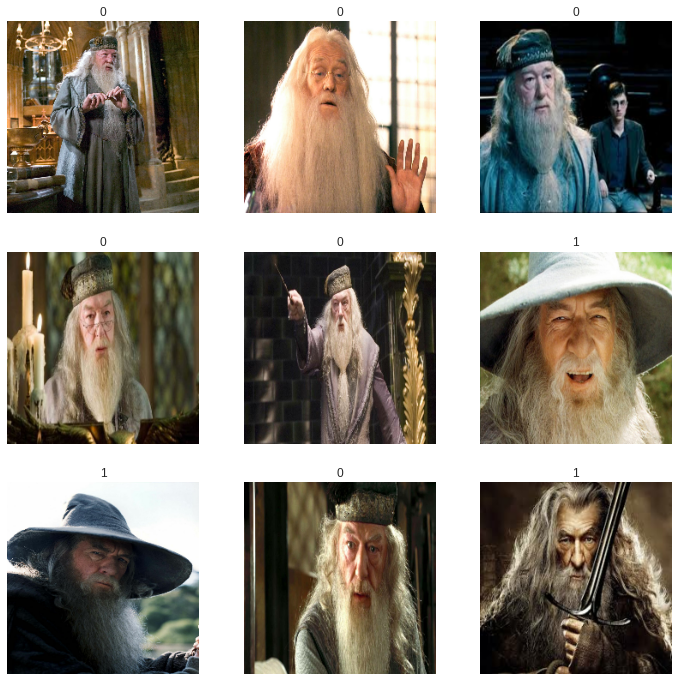

In [12]:
plot_sample_images(train_data, nrows=3, ncols=3)

After plotting the train data, the figure above shows that there are 2 categories, as we expected. The label 0 is assigned to Dumbledore and 1 is assigned to Gandalf.

For ensure that validate and test data contain 2 categories, the data will be plotted.

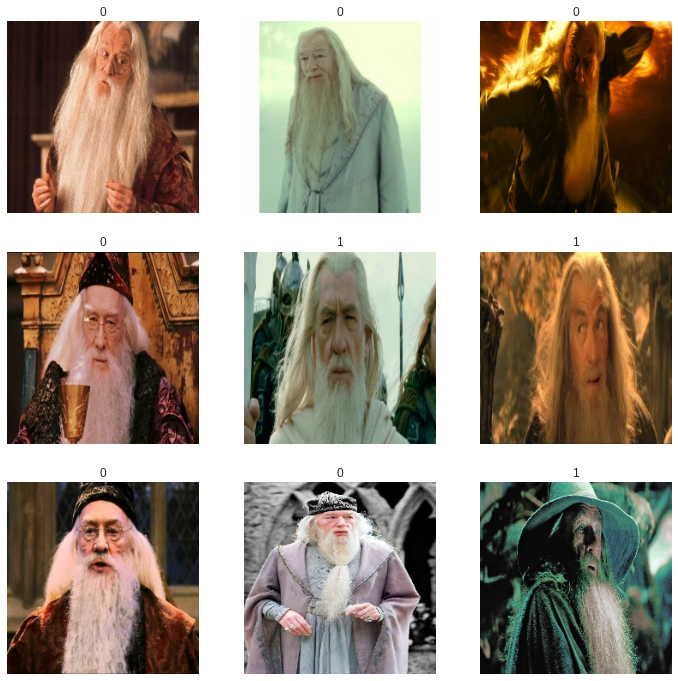

In [13]:
# Validation data
plot_sample_images(validation_data, nrows=3, ncols=3)

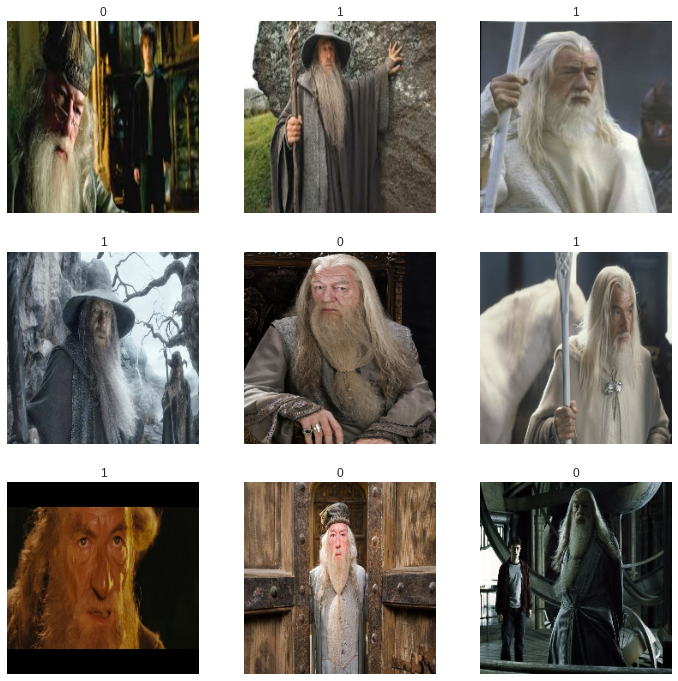

In [14]:
# Test data
plot_sample_images(test_data, nrows=3, ncols=3)

## Comentarios
---

Sobre las capas de **DATA AUGMENTATION**:

- No añadir el Rescaling (lo hace la red preentrenada).

Sobre las **CAPAS PREENTRENADAS**:
- Funciona mal si añadimos más convoluciones.

Sobre las **CAPAS DENSAS**: 

- No está claro si el Dropout ayuda o no al modelo.


Template para probar diferentes arquitecturas:
```
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

    # Data augmentation
    # model.add(layers.Rescaling(scale=1./255))
    model.add(layers.RandomRotation(factor=0.15, seed=SEED))
    model.add(layers.RandomFlip(seed=SEED))
    model.add(layers.RandomContrast(factor=0.1, seed=SEED))

    # Transfer Learning using ImageNet
    model.add(conv_base)

    # Our Neural Network
    # model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    # model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    # model.add(layers.Dense(16, activation="relu"))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation="relu"))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation="relu"))
    # model.add(layers.Dense(64, activation="relu"))
    # model.add(layers.Dense(128, activation="relu"))
    # model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(learning_rate=0.0001), 
        metrics=[metrics.BinaryAccuracy()]
    )

    return model
```

# Convolutional base

In [15]:
# Learning transferred from the ImageNet dataset.
conv_base = applications.EfficientNetB0(include_top=False, weights='imagenet')

# Freeze the layer not to train it.
conv_base.trainable = False

In [16]:
def construct_model(conv_base, fl_learning_rate):
    """Construct the Neural Network model."""

    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

    # Data augmentation
    model.add(layers.RandomRotation(factor=0.15, seed=SEED))
    model.add(layers.RandomFlip(seed=SEED))
    model.add(layers.RandomContrast(factor=0.1, seed=SEED))

    # Transfer Learning using ImageNet
    model.add(conv_base)

    # Our Neural Network
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(learning_rate=fl_learning_rate), 
        metrics=[metrics.BinaryAccuracy()]
    )

    return model

In [17]:
model = construct_model(conv_base, 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2

In [18]:
fit_parameters = {
    'epochs': 30,
    'earlyStopping_patient': 10
}
'''
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=fit_parameters['earlyStopping_patient']
)
'''
# Fit the train data
history = model.fit(train_data, 
                    epochs=fit_parameters['epochs'], 
                    #callbacks=early_stopping,
                    validation_data=validation_data
)

Epoch 1/30
2/2 [==============================] - 13s 3s/step - loss: 0.7252 - binary_accuracy: 0.5918 - val_loss: 0.9615 - val_binary_accuracy: 0.3333
Epoch 2/30
2/2 [==============================] - 1s 276ms/step - loss: 0.5676 - binary_accuracy: 0.6939 - val_loss: 0.9555 - val_binary_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 1s 269ms/step - loss: 0.4796 - binary_accuracy: 0.7959 - val_loss: 0.9738 - val_binary_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 1s 276ms/step - loss: 0.4251 - binary_accuracy: 0.7959 - val_loss: 0.9379 - val_binary_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 1s 280ms/step - loss: 0.3940 - binary_accuracy: 0.8571 - val_loss: 0.9854 - val_binary_accuracy: 0.5833
Epoch 6/30
2/2 [==============================] - 1s 275ms/step - loss: 0.3292 - binary_accuracy: 0.8571 - val_loss: 1.0780 - val_binary_accuracy: 0.5833
Epoch 7/30
2/2 [==============================] - 1s 273ms/step - loss: 0.2670

# Plot the model

In [19]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['binary_accuracy'])+1), model_history.history['binary_accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_binary_accuracy'])+1), model_history.history['val_binary_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Binary Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['binary_accuracy'])+1), len(model_history.history['binary_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


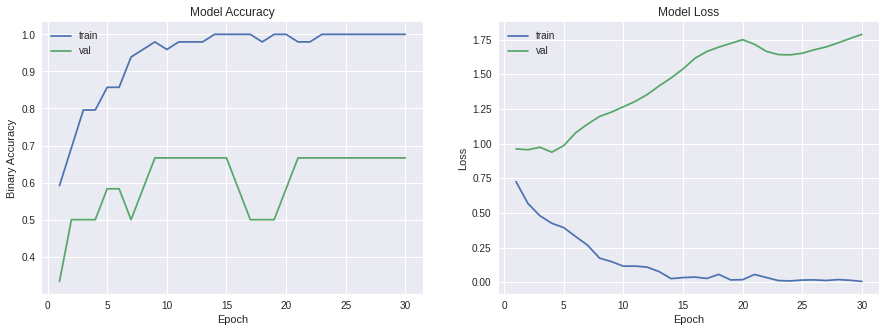

In [20]:
plot_model_history(history)

The train and valuation datas don't converge due to there aren't enough images.

In [21]:
train_all_data = preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="binary",
    class_names=CATEGORIES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 61 files belonging to 2 classes.


In [22]:
model = construct_model(conv_base, 0.0001)
model.fit(train_all_data, epochs=20)

Epoch 1/20
2/2 [==============================] - 10s 1s/step - loss: 0.7105 - binary_accuracy: 0.4918
Epoch 2/20
2/2 [==============================] - 1s 168ms/step - loss: 0.6275 - binary_accuracy: 0.7049
Epoch 3/20
2/2 [==============================] - 1s 168ms/step - loss: 0.5275 - binary_accuracy: 0.7705
Epoch 4/20
2/2 [==============================] - 1s 174ms/step - loss: 0.4269 - binary_accuracy: 0.8689
Epoch 5/20
2/2 [==============================] - 1s 170ms/step - loss: 0.3404 - binary_accuracy: 0.9180
Epoch 6/20
2/2 [==============================] - 1s 168ms/step - loss: 0.2868 - binary_accuracy: 0.9344
Epoch 7/20
2/2 [==============================] - 1s 169ms/step - loss: 0.2023 - binary_accuracy: 0.9344
Epoch 8/20
2/2 [==============================] - 1s 167ms/step - loss: 0.2064 - binary_accuracy: 0.9016
Epoch 9/20
2/2 [==============================] - 1s 170ms/step - loss: 0.2227 - binary_accuracy: 0.9180
Epoch 10/20
2/2 [==============================] - 1s 172

In [23]:
loss, binary_accuracy = model.evaluate(test_data)
loss, binary_accuracy

1/1 [==============================] - 2s 2s/step - loss: 0.3188 - binary_accuracy: 0.8333


(0.31875157356262207, 0.8333333134651184)

After applying the test data, the success percentage is 83%.

# Save the model

In [24]:
def save_model(model: models.Sequential):
    """Save the results of a model."""

    id = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
    model.save(f"huff_model_{id}.h5")

In [25]:
save_model(model)